In [2]:
from osgeo import gdal, osr
from rdp import rdp
from shapely.geometry import mapping, Polygon

import cv2
import numpy as np
import matplotlib.pyplot as plt
import fiona 
import fiona.crs

In [3]:
def Mask_to_Polygon(mask,geo_info,top_left_corner_pixel=[0,0]):
    
    poly = []
    rdp_epsilon = 1.5
#     top_left_corner_pixel = [0,0]
#    top_left_corner_pixel = [500,1500]
    top_left_corner_meter = geo_info['top_left_corner']
    x_meter_per_pixel = geo_info['mmp_x']
    y_meter_per_pixel = geo_info['mmp_y']
    #output_image = np.zeros([mask.shape[0],mask.shape[1],3],dtype=np.uint8)
    #mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    ## To-do: Add Polygonization Process here
    
    
    #output_image = cv2.drawContours(output_image, contour, -1, (0,255,0), 3)
    #gray_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
        
    for each_contour in contours:
        points = rdp(each_contour,epsilon=rdp_epsilon, algo="iter")
    
        if len(points) > 2:
            points = np.matmul((np.squeeze(points)+ top_left_corner_pixel),[[x_meter_per_pixel, 0] , [0, y_meter_per_pixel]])  + top_left_corner_meter
            p =Polygon(points)
            poly.append(p)

    return poly, contours

In [4]:
def Polygon_to_ShapeFile(poly, epsg, filename):
    
    # Define a polygon feature geometry with one attribute
    
    crs = fiona.crs.from_epsg(int(epsg))
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    
    
    # Write a new Shapefile
    with fiona.open(filename, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        for idx,each_poly in enumerate(poly):
            c.write({
                'geometry': mapping(each_poly),
                'properties': {'id': idx},
            })
            
        print(c)

In [5]:
def Seg_to_Polygon(data,x_meter_per_pixel, y_meter_per_pixel, top_left_corner_meter,score_threshold):
    
    poly = []
    
    for each_patch in data['patch']:        
        
        top_left_corner_pixel = each_patch['top_left']
        segmentation = each_patch['segmentation']
        score = segmentation['scores']
        for index, item in enumerate(segmentation['class_ids']):
            
            if score[index] < score_threshold:
                continue
            
            if item == 1:
                # Extract bounding box
                mask = segmentation['masks'][:,:,index]
                mask = mask.astype(np.uint8)
                contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for each_contour in contours:
                    points = rdp(each_contour,epsilon=1.5, algo="iter") 

                    if len(points) > 2:
                        points = np.matmul((np.squeeze(points)+ top_left_corner_pixel),[[x_meter_per_pixel, 0] , [0, y_meter_per_pixel]])  + top_left_corner_meter
                        p =Polygon(points)
                        poly.append(p)
        
    return poly

In [6]:
def getGeoTrans(img_file):
    
    gtif = gdal.Open(img_file)
    geoTrans = gtif.GetGeoTransform()
    

    mmp_x = geoTrans[1]
    mmp_y = geoTrans[5]
    top_left_corner = (geoTrans[0],geoTrans[3])
    
    img = cv2.imread(img_file)
    height, width, channels = img.shape 
    img_size = (height,width)
    
    
    # get Coordinate System
    geo_ref = []
    prj = gtif.GetProjection()
    srs = osr.SpatialReference(wkt=prj)
    if srs.IsProjected:
        geo_ref = srs.GetAttrValue('projcs')
    else:
        geo_ref = srs.GetAttrValue('geogcs')
    
    epsg = srs.GetAttrValue("AUTHORITY", 1)
    
    geo_info = {'mmp_x': mmp_x,
                'mmp_y': mmp_y,
                'top_left_corner': top_left_corner,
                'img_size': img_size,
                'geo_ref': geo_ref,
                'epsg': epsg
               }
    
    gtif = None
    
    return geo_info

In [7]:
img_file = "/Users/sukryool.kang/data/GIS_data/LosAngeles_2017/test_image/000032_000086-RGB-7cm.tif"
mask_image = "/Users/sukryool.kang/data/GIS_data/LosAngeles_2017/test_image/000032_000086-RGB-7cm.tif"
mask_image = "/Users/sukryool.kang/data/GIS_data/LosAngeles_2017/Unet_result/epoch_50_large_unet_large_data/results/000032_000086-RGB-7cm_000.tif"


img_file = "/Users/sukryool.kang/data/GIS_data/LosAngeles_2017/test_image/000032_000089-RGB-7cm.tif"
mask_image = "/Users/sukryool.kang/data/GIS_data/LosAngeles_2017/Unet_result/epoch_50_large_unet_large_data/results/000032_000089-RGB-7cm_013.tif"



In [8]:
geo_info = getGeoTrans(img_file)
img_size = (500,500)

In [9]:
print(geo_info)

{'mmp_x': 0.0700000002980232, 'mmp_y': -0.0700000002980232, 'top_left_corner': (379240.99677085876, 3764395.0212215185), 'img_size': (2000, 2000), 'geo_ref': 'WGS 84 / UTM zone 11N', 'epsg': '32611'}


In [10]:
th_val = 127
mask_img = cv2.imread(mask_image,cv2.IMREAD_GRAYSCALE)
binary, mask_img = cv2.threshold(mask_img, th_val, 255, cv2.THRESH_BINARY)

In [11]:
print(geo_info)

{'mmp_x': 0.0700000002980232, 'mmp_y': -0.0700000002980232, 'top_left_corner': (379240.99677085876, 3764395.0212215185), 'img_size': (2000, 2000), 'geo_ref': 'WGS 84 / UTM zone 11N', 'epsg': '32611'}


In [12]:
#poly,contours = Mask_to_Polygon(mask_img,geo_info)
poly,contours = Mask_to_Polygon(mask_img,geo_info,[500,1500])

In [13]:
Polygon_to_ShapeFile(poly,geo_info['epsg'],"test2.shp")

<open Collection 'test2.shp:test2', mode 'w' at 0x1250f1908>


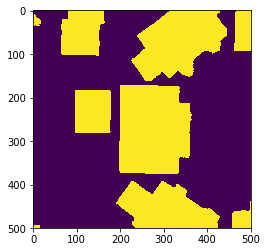

In [14]:
plt.imshow(mask_img)

In [15]:
np.max(mask_img)

255

In [16]:
print(mask_img)

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [17]:
contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
new_contours = []
for each_contour in contours:
    new_contours.append(rdp(each_contour,epsilon=1.0, algo="iter"))
    

In [18]:
output_image = np.zeros([500,500,3],dtype=np.uint8)

# cv2.drawContours(output_image, contours, -1, (0,255,0), 3)

color = [(0,255,0),(255,0,0),(0,0,255)]

for idx, each_contour in enumerate(new_contours):
    print(len(new_contours[idx]), len(contours[idx]))
    cv2.drawContours(output_image, [each_contour],0, color[idx%3], 3)
    

6 9
10 26
43 234
10 48
29 86
15 38
3 4
3 4
5 13
62 289
11 44


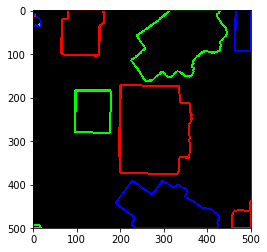

In [19]:
plt.imshow(output_image)

In [20]:
gray = cv2.cvtColor(output_image,cv2.COLOR_BGR2GRAY)
binary,binary_img = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
#edges = cv2.Canny(gray,50,150,apertureSize = 3)
# lines = cv2.HoughLines(binary_img,1,np.pi/180,200)

minLineLength = 1
maxLineGap = 100
lines = cv2.HoughLinesP(binary_img,1,np.pi/180,100,minLineLength,maxLineGap)

In [21]:
np.max(edges)

NameError: name 'edges' is not defined

In [22]:
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(output_image,(x1,y1),(x2,y2),(0,255,255),2)

ValueError: too many values to unpack (expected 2)

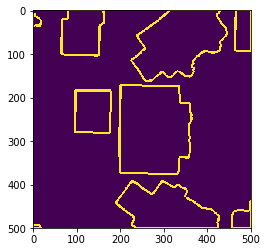

In [23]:
# plt.imshow(output_image)
plt.imshow(binary_img)

# Polygonization Test

In [88]:
rgb_img = cv2.imread(img_file)
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
crop_img = rgb_img[1500:2000, 500:1000,:]

contours1, hierarchy1 = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours2, hierarchy2 = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [89]:
tmp_image = np.zeros([500,500,3],dtype=np.uint8)

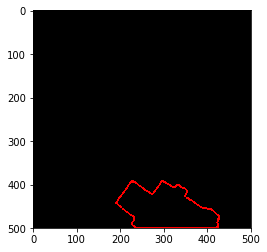

In [92]:
cv2.drawContours(tmp_image, [contours1[2]],0, [255,0,0], 3) 
plt.imshow(tmp_image)

# Corner Point Detection

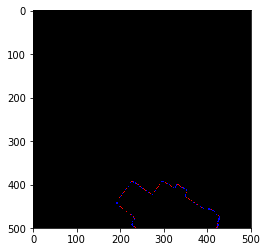

In [172]:
tmp_image = np.zeros([500,500,3],dtype=np.uint8)
cv2.drawContours(tmp_image, [contours1[2]],0, [255,0,0], 1) 
tmp_gray = cv2.cvtColor(tmp_image,cv2.COLOR_BGR2GRAY)
gray = np.float32(tmp_gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

tmp_image[dst>0.01*dst.max()]=[0,0,255]


plt.imshow(tmp_image)



# Hough Line Transform

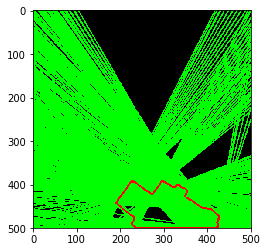

In [158]:
tmp_image = np.zeros([500,500,3],dtype=np.uint8)
cv2.drawContours(tmp_image, [contours1[2]],0, [255,0,0], 3) 
tmp_gray = cv2.cvtColor(tmp_image,cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(tmp_gray,0,255,cv2.THRESH_BINARY)
lines = cv2.HoughLines(thresh1,1,np.pi/180,30)

for each_line in lines:
    rho,theta = each_line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(tmp_image,(x1,y1),(x2,y2),(0,255,0),2)

cv2.drawContours(tmp_image, [contours1[2]],0, [255,0,0], 3) 
plt.imshow(tmp_image)

53


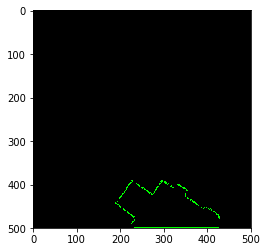

In [169]:
tmp_image = np.zeros([500,500,3],dtype=np.uint8)
minLineLength = 10
maxLineGap = 1
lines = cv2.HoughLinesP(thresh1,1,np.pi/180,30,minLineLength,maxLineGap)

for each_line in lines:
    x1,y1,x2,y2 = each_line[0]
    cv2.line(tmp_image,(x1,y1),(x2,y2),(0,255,0),1)

print(len(lines))
plt.imshow(tmp_image)

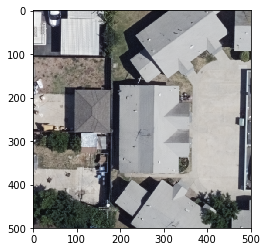

In [53]:
plt.imshow(crop_img)

# Edge Detection - not so useful

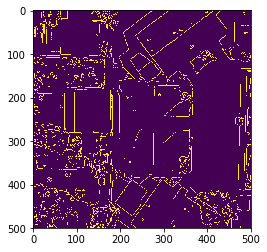

In [165]:
gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize = 3)
#edges = cv2.Canny(gray,100,200)
plt.imshow(edges)